# DSCI 100: Group 20 Project Proposal

**Date**: *July 30th, 2021*

**Authors**: *Thomas Cowan, Marcela Flaherty, Tony Liang, Hamidreza Yarveicy*

### Import necessary packages

In [3]:
# httr, ggplot2, and GGally were all available without installation on the DSCI 100 Jupyter Hub, but if errors occur, please install these packages.
library(tidyverse)
library(tidymodels)
library(repr)
library(httr)
library(readxl)
library(ggplot2)
library(GGally)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.16
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## Introduction

Pulsars are a type of dense, highly magnetized star that emits periodic radio bursts from its rotational poles$^{[1]}$. Limited research has been conducted on the detection of pulsars with the use of data science methods. We will attempt to answer the following question: 

> Can pulsar radio emissions be accurately differentiated from radio frequency interference (RFI) and radio noise?

To address this question properly, we will investigate a collection of radio emissions recorded during the [High Time Resolution Universe Pulsar Survey](https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip)$^{[2]}$ (HTRU2). It contains 16,259 examples caused by RFI/noise and 1,639 real pulsars.

The HTRU2 data set contains statistics on signal-to-noise ratios (SNR) and integrated profiles (a method of stacking multiple measurements of the same pulsar) of areas of The Southern Hemisphere. 

![image](https://i.imgur.com/JpWpvRr.gif)

![image](https://i.imgur.com/JLhFw1A.gif)


[Joeri van Leeuwen. License: CC-BY-AS](https://www.astron.nl/pulsars/animations/)

[Essentials of Radio Astronomy](https://www.cv.nrao.edu/~sransom/web/Ch6.html)

**Fig. 1** An artist's animation (top) of a radio profile from a pulsar, and a series of these profiles from a single star integrated together (bottom).

## Methods and Results

#### Download Pulsar Data

In [4]:
# Download zipped Pulsar data from PULSAR_URL
PULSAR_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
GET(PULSAR_URL, write_disk(tf <- tempfile(fileext = ".zip")))

# Unzip the tempfile and read the csv inside it, renaming the columns as below
# then mutate the target class to a meaningful value for a human and convert to a factor
pulsar_data_raw <- read_csv(unz(tf, "HTRU_2.csv"), col_names = c("mean_ip", 
                                                             "std_ip", 
                                                             "excess_kurtosis_ip", 
                                                             "skewness_ip", 
                                                             "mean_dm_snr", 
                                                             "std_dm_snr", 
                                                             "excess_kurtosis_dm_snr", 
                                                             "skewness_dm_snr", 
                                                             "target_class")) %>% 
                 mutate(target_class = as_factor(case_when(
                                                target_class == 1 ~ "pulsar",
                                                TRUE ~ "rfi_noise")))  
# unlink/remove the temporary file
unlink(tf)

# preview the data
pulsar_data_raw %>% head(5)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip]
  Date: 2021-08-13 05:02
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 1.56 MB
<ON DISK>  /tmp/RtmptCX4K2/file29c927c1b182.zipNULL

Parsed with column specification:
cols(
  mean_ip = col_double(),
  std_ip = col_double(),
  excess_kurtosis_ip = col_double(),
  skewness_ip = col_double(),
  mean_dm_snr = col_double(),
  std_dm_snr = col_double(),
  excess_kurtosis_dm_snr = col_double(),
  skewness_dm_snr = col_double(),
  target_class = col_double()
)



mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,rfi_noise
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,rfi_noise
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,rfi_noise
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rfi_noise
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rfi_noise


### Data Summary and Recipe Construction
The pulsar data is tidy, but it suffers from a large class imbalance: only ~9% of our dataset is classified as a true pulsar. This can be a significant source of error in a final KNN model if it is not addressed in the training data processing. Below we will:
- Split our data into 60% training and 40% testing
- Create a recipe which will upsample our training data to better balance the class distribution
- Plot the old and new class numbers next to eachother to highlight the effect of this upsampling in terms of class labels

We believe our 60/40 train/test split is a good compromise between model speed and accuracy. We saw severe training slowdowns for training splits above 60% which is expected for KNN models with large underlying training sets and many potential predictors. 

In [5]:
set.seed(1) # set the random seed so that sample_frac selects the same rows each run
pulsar_split <- initial_split(pulsar_data_raw, prop = 0.5, strata = target_class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


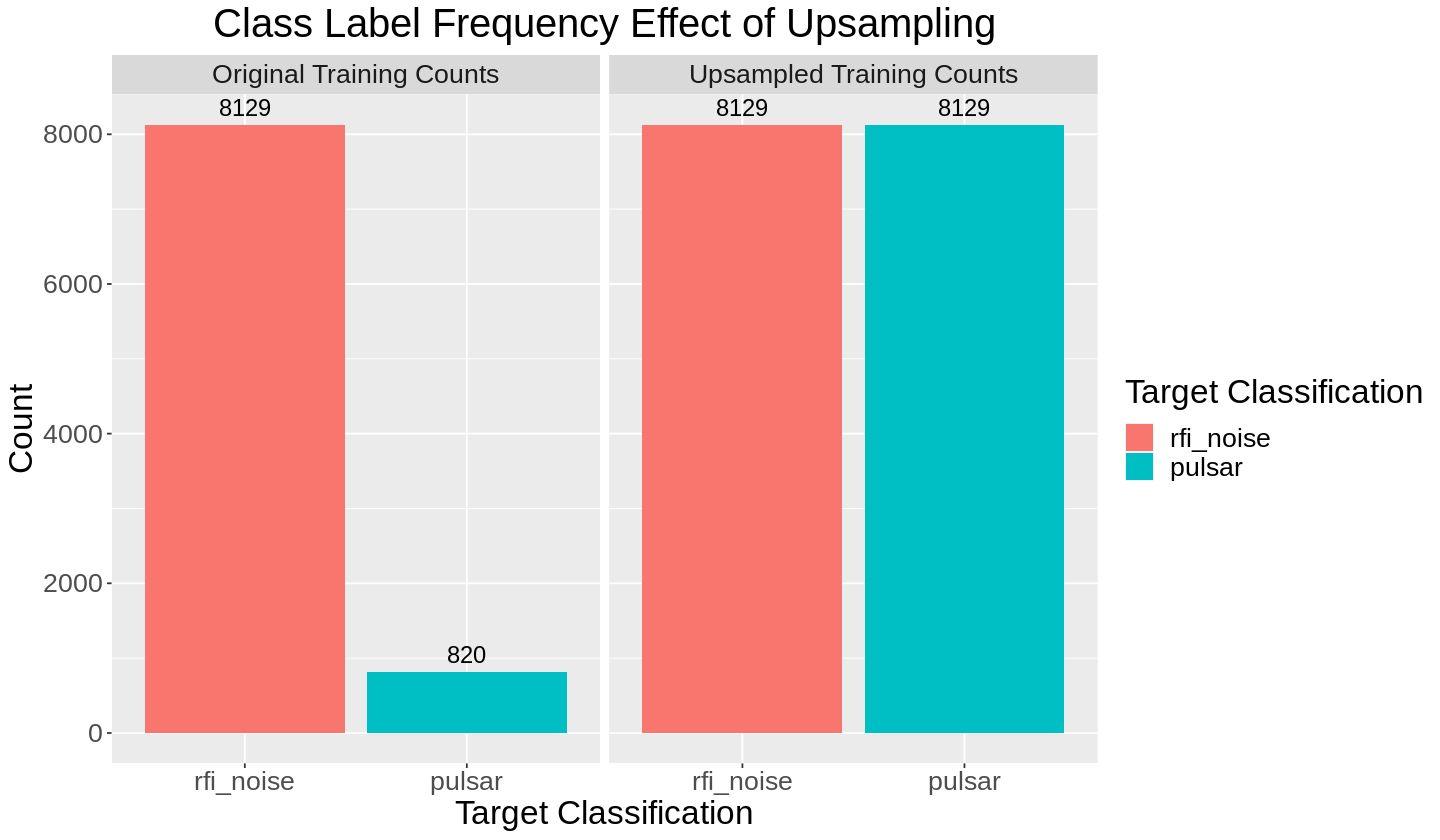

In [6]:
options(repr.plot.width = 12, repr.plot.height = 7)

# create upsample recipe to combat class imbalance in the original data set
pulsar_upsample_recipe <- recipe(target_class ~ ., data = pulsar_train) %>% 
                    step_center(all_predictors()) %>% 
                    step_scale(all_predictors()) %>% 
                    step_upsample(target_class, over_ratio = 1)

pulsar_train_prepped <- pulsar_upsample_recipe %>% 
                    prep() %>% 
                    bake(new_data=NULL)

# merge original and upsampled data for side-by-side plotting purposes
join_by = c("mean_ip", "std_ip", "excess_kurtosis_ip",
            "skewness_ip", "mean_dm_snr", "std_dm_snr", 
            "excess_kurtosis_dm_snr", "skewness_dm_snr", 
            "target_class", "is_prepped")

pulsar_train_prepped_merge <- full_join(pulsar_train %>% mutate(is_prepped = FALSE),
                                        pulsar_train_prepped %>% mutate(is_prepped = TRUE),
                                        by = join_by)



upsample_compare_bar_plot <- pulsar_train_prepped_merge %>% 
                        ggplot(aes(x = target_class, fill = target_class)) + 
                            geom_bar() +
                            labs(x = "Target Classification", 
                                 y = "Count",
                                 fill = "Target Classification") +
                            geom_text(stat='count', aes(label=..count..), vjust = -0.5, size=5) +
                            ggtitle("Class Label Frequency Effect of Upsampling") +
                            theme(text = element_text(size=20),
                                  plot.title = element_text(hjust = 0.5)) +
                        facet_wrap(~ is_prepped,
                                   labeller = labeller(is_prepped = c("TRUE" = "Upsampled Training Counts", 
                                                                      "FALSE" = "Original Training Counts")))
upsample_compare_bar_plot

**Fig. 2** After upsampling with a target ratio of 1:1 we can see that 8,717 new pulsar points have been generated.

#### Summary stats of the unscaled pulsar data
The following table summarizes the max, min, mean, variance, standard deviation, and number of NaNs for each variable for the unscaled pulsar data.

In [7]:
min_df <- pulsar_train %>% 
            select(-target_class) %>% 
            map_df(min)
max_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(max)
mean_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(mean)
sd_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(sd)
var_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(var)
count_nan_df <- pulsar_train %>% 
                select(-target_class) %>% 
                map_df(~sum(is.na(.)))

# get a vector of all the columns to join by
join_cols = colnames(pulsar_train %>% select(-target_class))

# join the stats tables together
stats_table <- full_join(min_df, max_df, by=join_cols) %>% 
                full_join(., mean_df, by=join_cols) %>% 
                    full_join(., var_df, by=join_cols) %>% 
                        full_join(., sd_df, by=join_cols) %>%
                            full_join(., count_nan_df, by=join_cols) %>%
                mutate(stat_type = c("min", "max", "mean", "var", "st_dev", "nan_count")) %>% 
                mutate(stat_type = as_factor(stat_type)) %>% 
                relocate(stat_type)

print("Unscaled Training Data Statistics Summary")
stats_table

[1] "Unscaled Training Data Statistics Summary"


stat_type,mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
min,6.179688,24.791612,-1.8760112,-1.781888,0.2132107,7.370432,-3.139270,-1.964998
max,192.617188,98.778911,8.0695220,68.101622,223.3921405,107.947490,34.539844,1191.000837
mean,110.967121,46.506850,0.4775022,1.760162,12.7007876,26.289515,8.315404,105.369053
var,656.664374,47.182994,1.1199679,37.211915,885.3437651,375.850249,20.653044,11927.734346
st_dev,25.625463,6.868988,1.0582853,6.100157,29.7547268,19.386858,4.544562,109.214167
nan_count,0.000000,0.000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000


#### Exploratory Plotting
The pair plot (Fig. 3) below shows the distributions and relationships between all the variables in the data set, colored by target_class. Visually there appears to be to be good class separation for integrated profile statisitics (those postfixed with `_ip`) and moderate to poor class separation for the noise statistics (those postfixed with `_dm_snr`). The kernel density estimates also show fairly good class label separation between all the variables.

For the final predictor selection we will use forward selection as described in section 6.6.3 of the textbook

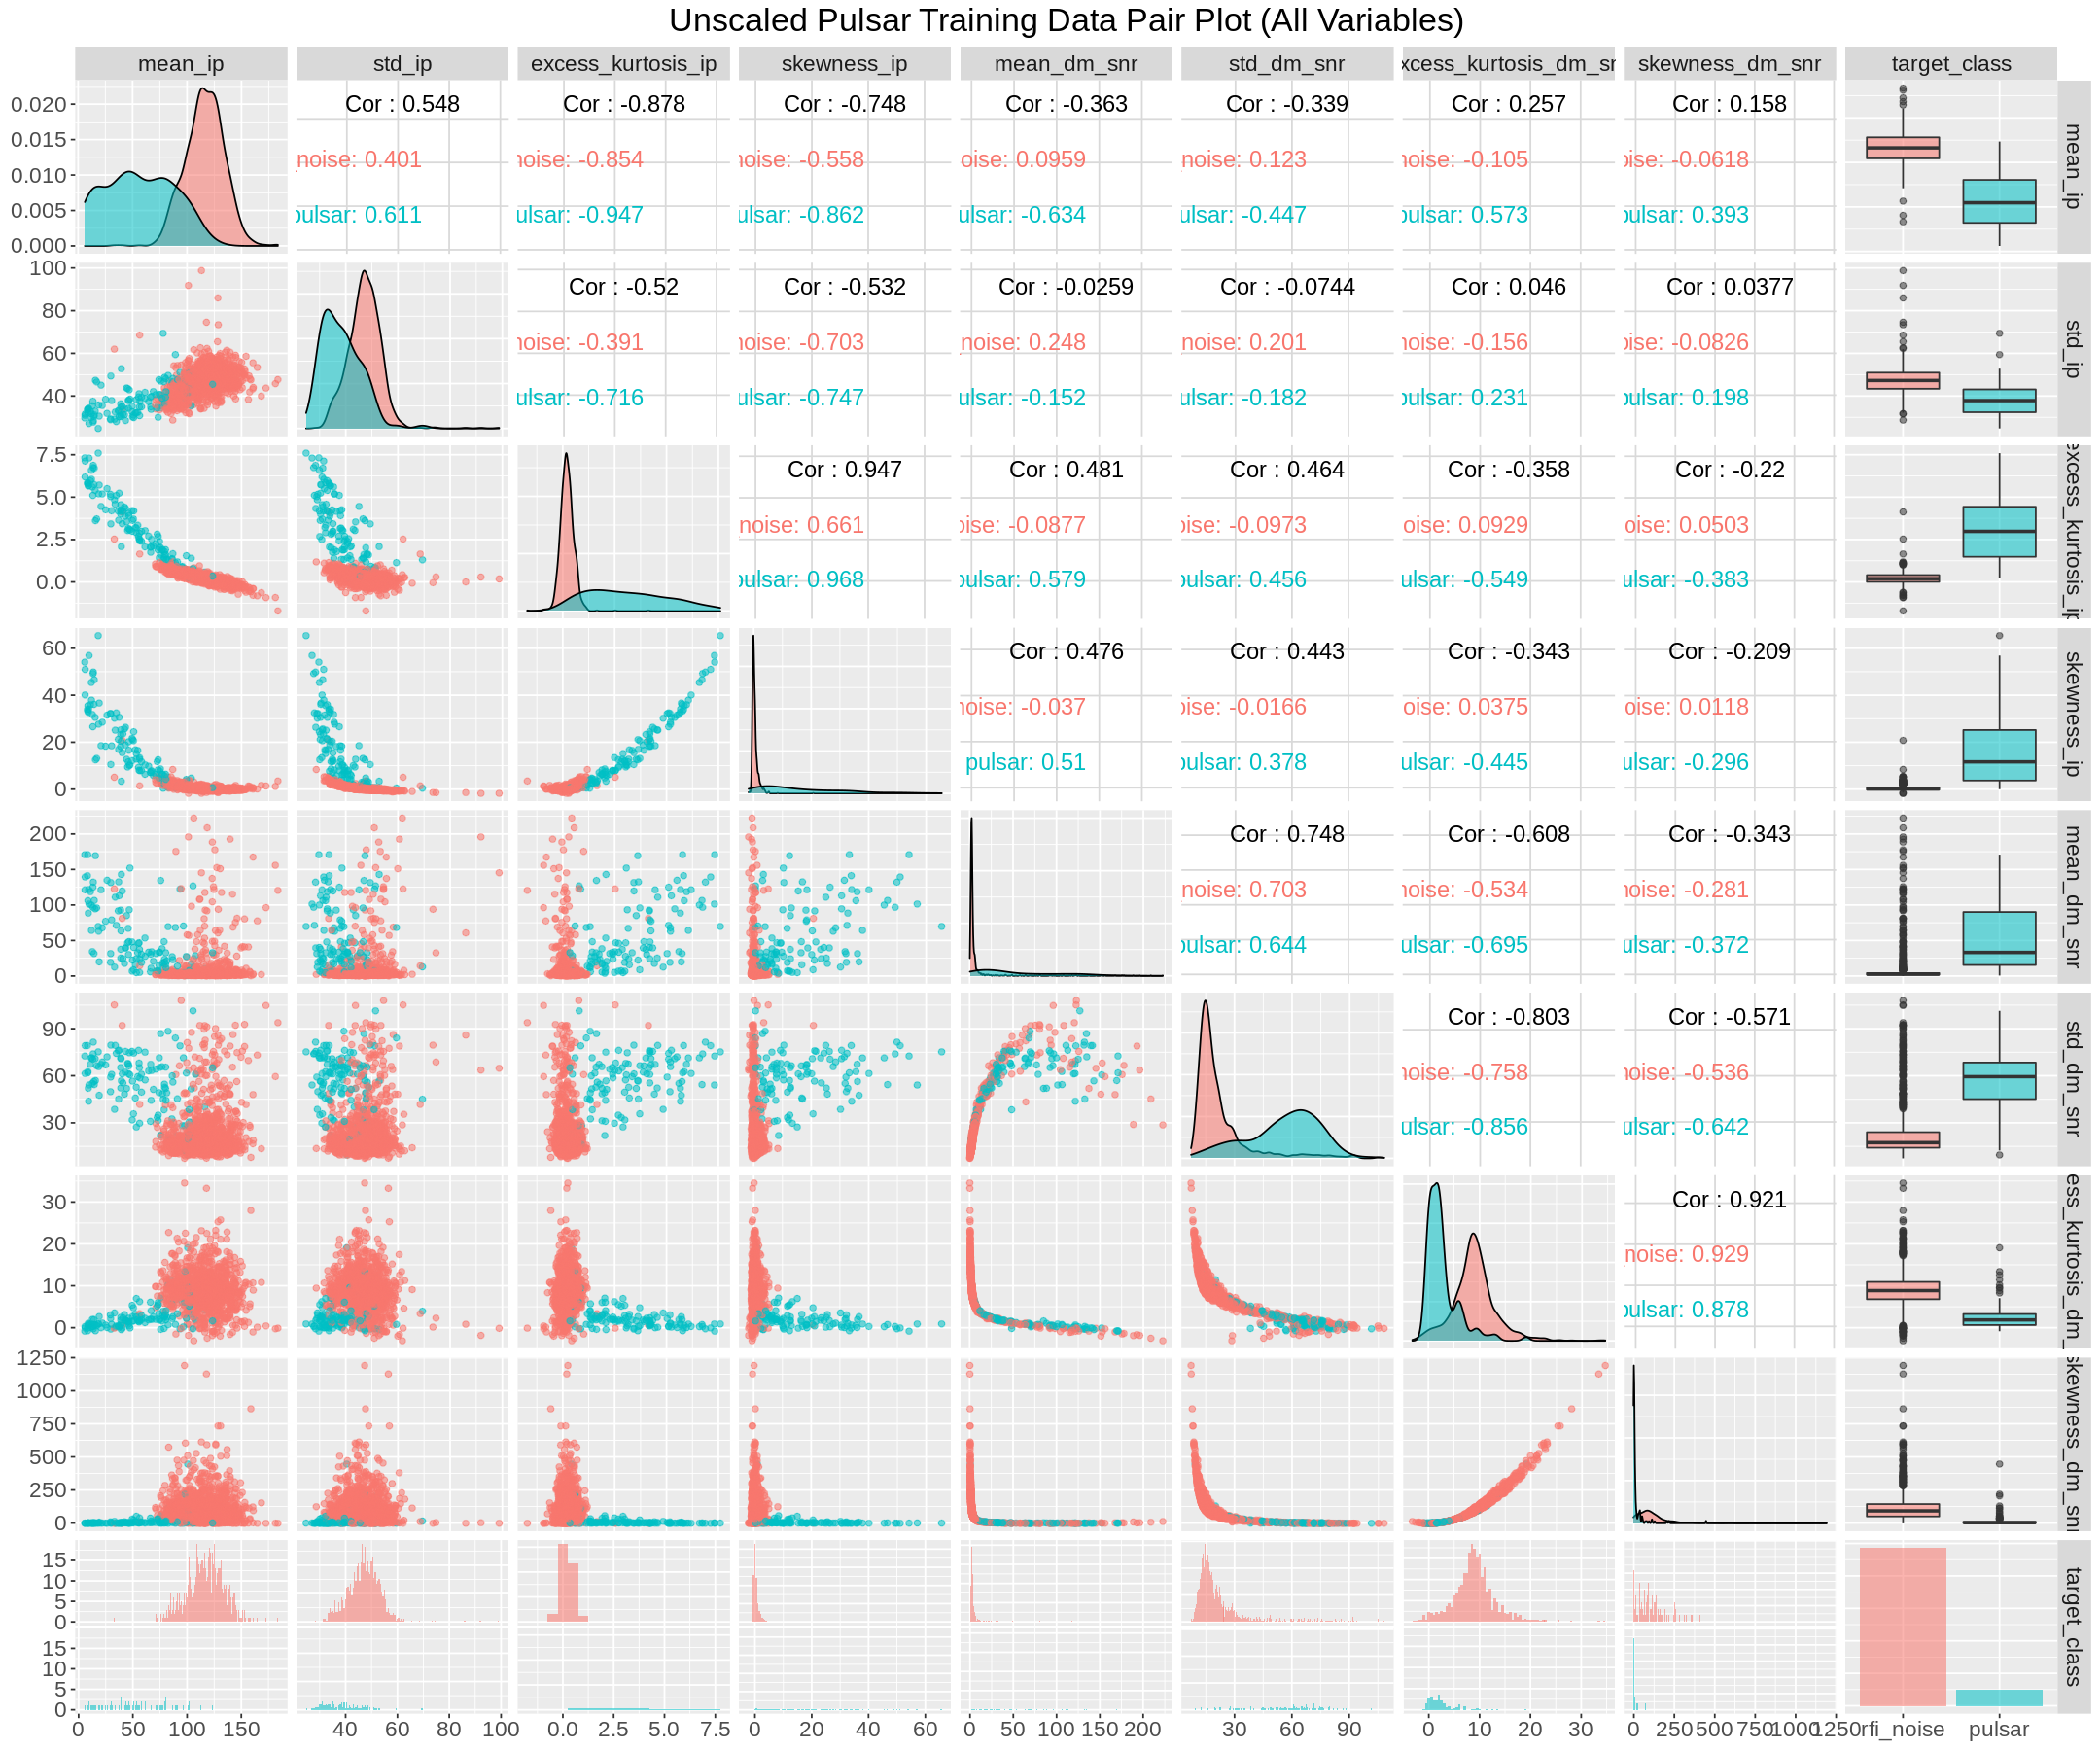

In [8]:
options(repr.plot.width = 18, repr.plot.height = 15)

# subset of the data for faster plotting
pulsar_scaled_subset <- pulsar_train %>% sample_frac(0.15) 

ggpairs(pulsar_scaled_subset,
           mapping = aes(color=target_class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.5)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Unscaled Pulsar Training Data Pair Plot (All Variables)") +
        theme(text = element_text(size = 17),
              plot.title = element_text(hjust = 0.5))
        

**Fig. 3** A pair plot of unscaled pulsar training data. The displayed data is a random subset (15%) of the training data to improve plot readability and performance.

### Forward Selection of Predictors

We will use the scaled and upsampled training data for predictor selection.

In [9]:
# Workflow adapted from 6.6.3 in the DSCI 100 textbook

set.seed(1) # reset the seed so that this cell produces the same results no matter what order it is run in

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-valication object
pulsar_vfold <- vfold_cv(pulsar_train, v = 5 , strata = target_class)

# store the total number of predictors
names = colnames(pulsar_train %>% select(-target_class))
n_total <- length(names)

# create a vector to store selected predictors
selected <- c()

# for each predictor
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("target_class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        pulsar_loop_recipe <- recipe(as.formula(model_string), data = pulsar_train) %>% 
                    step_center(all_predictors()) %>% 
                    step_scale(all_predictors()) %>% 
                    step_upsample(target_class, over_ratio = 1)

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(pulsar_loop_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = pulsar_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}


# Methods 

This is a classification problem, and we will make use of a KNN model for our predictions, tuned using the v-fold cross-validation methods we learned in worksheet 7.

The HTRU2 data set has several thousand entries (17,898), and there is considerable overlap between pulsars and radio noise in many of the provided variables. 80% of our data will be reserved for training, as we believe our model will require a significant proportion of our data to distinguish between classes in these overlapping zones.

We will exclude "mean_dm_snr", "excess_kurtosis_dm_snr", and "skewness_dm_snr" from our model as these variables do not provide good separation when plotted against the other available data. Plots of two of these exlcuded variables are below. 

Among other plots, we will use scatter plots colored by correct/incorrect predictions to visualize the areas where the model struggles.


#### Plot of Accuracy 

size,model_string,accuracy
<int>,<chr>,<dbl>
1,target_class ~ excess_kurtosis_ip,0.9630133
2,target_class ~ excess_kurtosis_ip+mean_dm_snr,0.9669236
3,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip,0.9699406
4,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip,0.9715047
5,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip+skewness_ip,0.9715048
6,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip+skewness_ip+std_dm_snr,0.9709462
7,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip+skewness_ip+std_dm_snr+skewness_dm_snr,0.9710583
8,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip+skewness_ip+std_dm_snr+skewness_dm_snr+excess_kurtosis_dm_snr,0.9703879


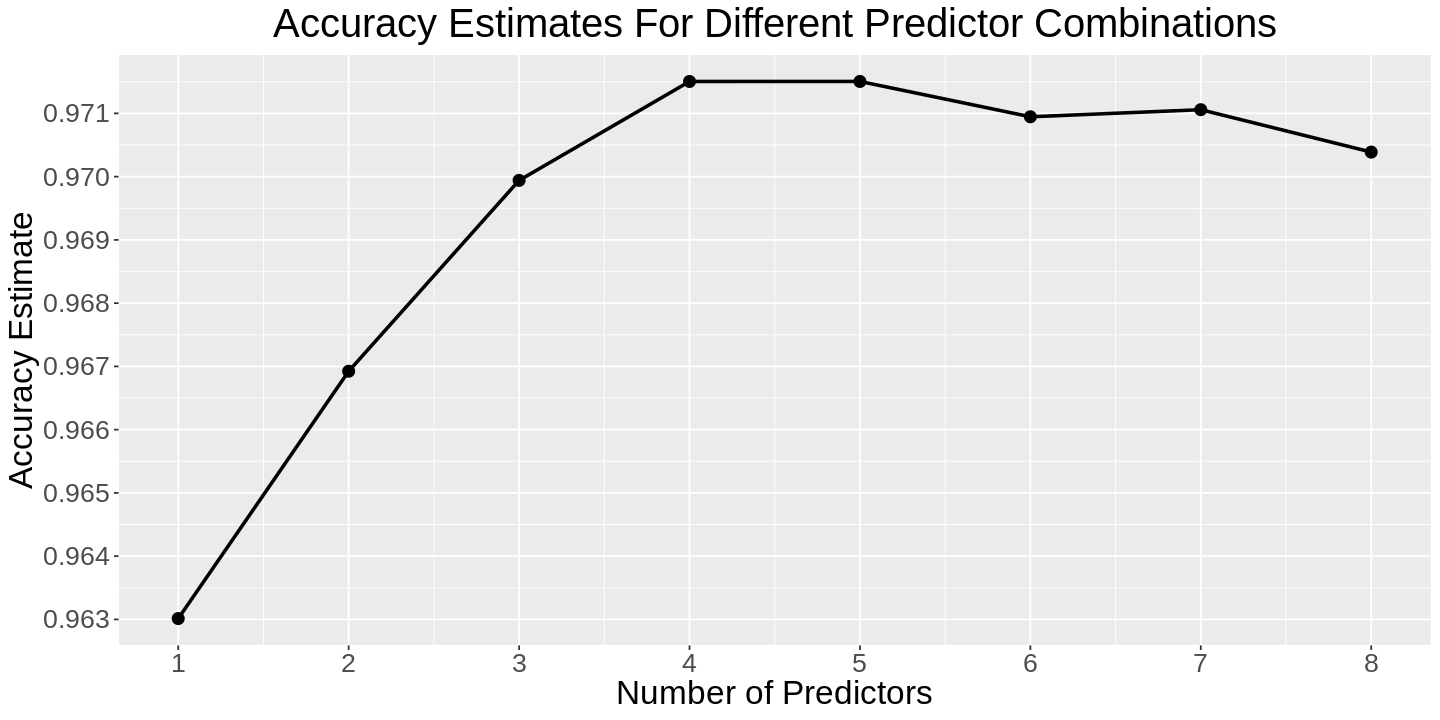

In [10]:
options(repr.plot.width = 12, repr.plot.height = 6)

accuracy_plots_num_predictors <- accuracies %>% 
    ggplot(aes(x = size, y = accuracy)) +
        geom_line(size=1) + geom_point(size=3) + 
        labs(x = "Number of Predictors", y = "Accuracy Estimate") +
        scale_y_continuous("Accuracy Estimate", seq(0.94, 1.0, 0.001)) +
        scale_x_continuous("Number of Predictors", c(1:8)) +
        ggtitle("Accuracy Estimates For Different Predictor Combinations") +
        theme(text = element_text(size=20),
              plot.title = element_text(hjust = 0.5))

accuracy_plots_num_predictors
accuracies

**Fig. 4** Plot if the accuracy estimates for different predictor combinations, showing 4-5 predictors as the maximum estimated accuracy.

### Fitting the Model 
Next, we conduct another v-fold cross-validation using our optimum predictors `target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip` in order to determine the optimum $k$ parameter for our nearest neighbor classification.

In [11]:
#kknn specification with euclidean distance
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
                set_engine("kknn") %>%
                set_mode("classification")
# set 5 folds 
pulsar_vfold <- vfold_cv(pulsar_train, v = 5 , strata = target_class)

# cross validation to find accuracy of different k neighbors when using specified variables as predictors
optimum_recipe <- recipe(target_class ~ excess_kurtosis_ip + 
                                        mean_dm_snr + std_ip + 
                                        mean_ip, 
                                        data = pulsar_train) %>% 
                        step_center(all_predictors()) %>% 
                        step_scale(all_predictors()) %>% 
                        step_upsample(target_class, over_ratio = 1)

knn_results <- workflow() %>%
    add_recipe(optimum_recipe) %>% 
    add_model(knn_spec) %>%
    tune_grid(resamples = pulsar_vfold, grid = 10)  %>%
    collect_metrics() 
                  
                

In [12]:
# filter out the accuracies of each neighbor
accuracy_estimates <- knn_results%>%
              filter(.metric %in% c("accuracy"))

# Pulls out the optimal k value for the model
k_best <- accuracy_estimates %>%
          arrange(desc(mean)) %>%
          slice(2) %>%
          pull(neighbors)  

# Creating new spec based on optimal K
best_spec <- nearest_neighbor(weight_func = "rectangular" , neighbor = k_best) %>%
              set_engine("kknn") %>%
              set_mode("classification")

# Fit the model
pulsar_fit <- workflow() %>%
             add_recipe(optimum_recipe) %>%
             add_model(best_spec) %>%   
             fit(data = pulsar_train)

# Predict the testing data with our fitted model
pulsar_predictions <- predict(pulsar_fit, pulsar_test) %>%
                     bind_cols(pulsar_test)

# Estimate of the truth and our predictive class
pulsar_metrics <- pulsar_predictions %>%
                 metrics(truth = target_class , estimate = .pred_class)

# Confustion matrix of truth and our predictive class
pulsar_conf_mat <- pulsar_predictions %>%
                  conf_mat(truth = target_class, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9643536
kap,binary,0.7958317


           Truth
Prediction  rfi_noise pulsar
  rfi_noise      7925    114
  pulsar          205    705

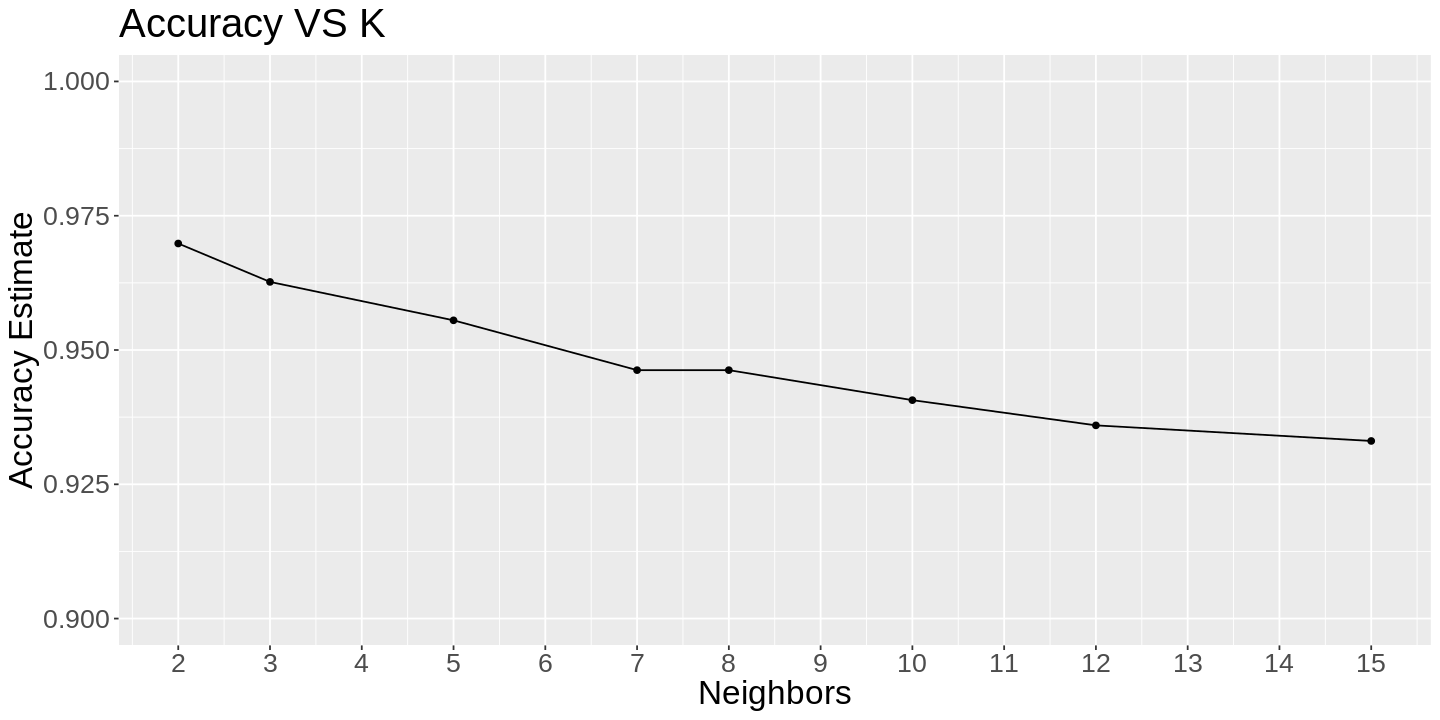

In [13]:
# plot the accuracy of each k neighbors with excluded predictors
accuracy_versus_k <- ggplot(data = accuracy_estimates, aes (x = neighbors, y = mean)) + 
                         geom_point() + 
                         geom_line() +
                         labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy VS K") + 
                         scale_x_continuous(breaks = seq(0, 100, by = 1)) + 
                         scale_y_continuous(limits = c (0.9 , 1.0)) +
                         theme(text = element_text (size = 20))   
accuracy_versus_k
pulsar_metrics 
pulsar_conf_mat

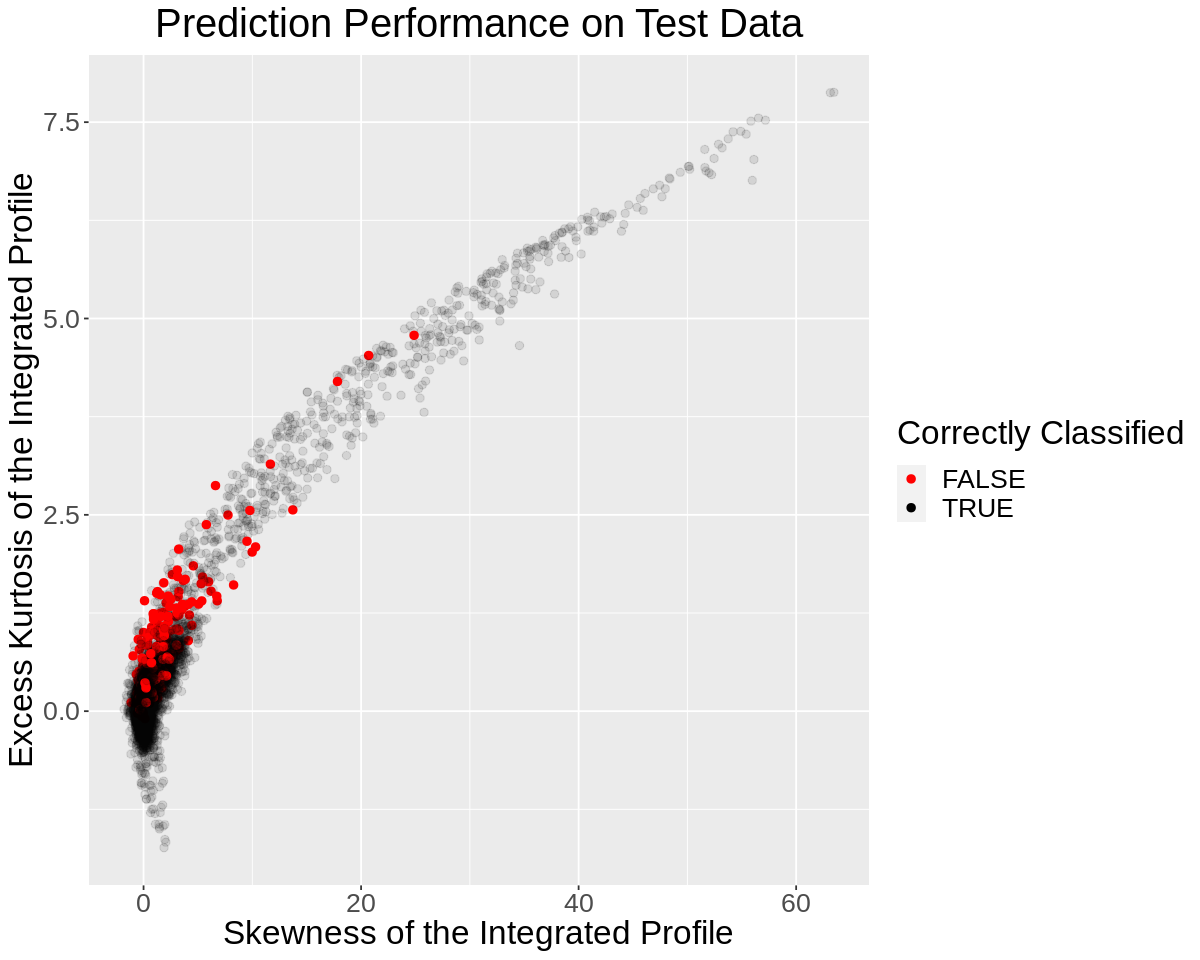

In [15]:
options(repr.plot.width = 10, repr.plot.height = 8)

pulsar_predictions %>%
    mutate(correct = (.pred_class == target_class)) %>% 
    ggplot(aes(x = skewness_ip, y = excess_kurtosis_ip, color = correct, alpha = correct)) +
    labs(x = "Skewness of the Integrated Profile",
         y = "Excess Kurtosis of the Integrated Profile", 
         color = "Correctly Classified",
         alpha =  "Correctly Classified") + 
    ggtitle("Prediction Performance on Test Data") +
    scale_color_manual(values = c("red", "black")) +
    geom_point(size = 2) +
    scale_alpha_manual(guide = 'none', values = c("FALSE" = 1, "TRUE" = 0.1)) +
    theme(text = element_text(size = 20),
          plot.title = element_text(hjust = 0.5))


# Expected Outcomes and Significance
We expect to be able to distinguish between a pulsar star and radio noise using statistical predictors.

### Impact of Findings
Pulsars allow us to study extreme states of matter, investigate beyond our solar system, and measure interstellar distances$^{[3]}$. Information gleaned from studying pulsars has broad applicability, and rapid, efficient, and accurate delineation of the pulsar star/radio noise boundary is scientifically significant.

### Future Questions
One of the most significant impacts of pulsar analysis is the study of space-time, this is because of the pulse, or blinking, that occurs with a pulsar. Through this natural clock, we can use pulsars when asking questions about distance and time between objects in space $^{[4]}$.


# Citations
$^{[1]}$Smith, F. G. (1977). Pulsars. *Cambridge Monographs on Physics*

$^{[2]}$R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, *Fifty Years of Pulsar
		Candidate Selection: From simple filters to a new principled real-time classification approach
		MNRAS*, 2016.

$^{[3]}$Cofield, C. (2016, April 22). *What are pulsars?* Space.com. https://www.space.com/32661-pulsars.html.*

$^{[4]}$NASA. (2011, January). *Pulsars*. NASA. https://imagine.gsfc.nasa.gov/science/objects/pulsars2.html.old.